In [1]:
import torch
print(torch.cuda.is_available()) # should be True
# t = torch.rand(10, 10).cuda()
# print(t.device) # should be CUDA]
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from PIL import Image
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio



True


### tasks
- check heatmap relibaility through tests

## Test heatmap reliability

In [33]:

def various_distance(out_vec_t0, out_vec_t1,dist_flag):
    if dist_flag == 'l2':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)
    if dist_flag == 'l1':
        distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=1)
    if dist_flag == 'cos':
        distance = 1 - F.cosine_similarity(out_vec_t0, out_vec_t1)
    return distance

In [34]:
def various_distance1(tensor_a, tensor_b, dist_type):
    """Compute a simple squared difference assuming 'l2' means Euclidean."""
    if dist_type == 'l2':
        return (tensor_a - tensor_b) ** 2
    else:
        raise ValueError("Unsupported distance type")

In [35]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.zeros([100, 128, 12])
input2 = torch.randn(100, 128, 12)
print(input1.shape  , input2.shape)
print(pdist(input1, input2))
print(various_distance1(input1, input2, 'l2'))
print(various_distance(input1, input2, 'l2'))

torch.Size([100, 128, 12]) torch.Size([100, 128, 12])
tensor([[2.4469, 2.9400, 3.8676,  ..., 3.3183, 4.2914, 1.9747],
        [3.9285, 3.9510, 4.0567,  ..., 3.2019, 2.7593, 3.6369],
        [3.5884, 4.1240, 3.3622,  ..., 3.6095, 3.6335, 4.3030],
        ...,
        [3.2054, 2.0570, 3.9920,  ..., 1.9317, 3.5473, 2.9166],
        [2.7090, 3.6352, 2.6369,  ..., 3.6173, 3.9989, 3.1419],
        [3.7298, 4.1061, 3.8887,  ..., 3.9809, 2.5687, 3.4002]])
tensor([[[4.7407e-02, 8.8523e-01, 1.5144e-02,  ..., 2.7562e+00,
          4.1148e-05, 3.8451e-01],
         [1.0194e+00, 6.5983e-01, 3.8207e-02,  ..., 7.7936e-01,
          1.0567e-01, 8.5427e-02],
         [3.1662e+00, 3.2037e-01, 8.6825e-01,  ..., 8.9877e-01,
          8.7908e-05, 1.2134e-01],
         ...,
         [4.2171e+00, 2.4773e+00, 1.5125e-01,  ..., 1.5934e-02,
          6.5643e-01, 2.5160e-02],
         [5.4381e+00, 2.6042e-01, 2.6415e+00,  ..., 3.0122e+00,
          1.5180e+00, 1.2626e-01],
         [5.7844e-02, 2.1081e-01, 2.725

In [ ]:
# Create synthetic data where the distance should be easy to validate

output_t0 = torch.zeros((1, 1, 10, 10, 10))
output_t1 = torch.zeros_like(output_t0)
output_t0[0, 0, 5, 5, 5] = 1  # Set a single point to a high value
print("Output tensor shape:", output_t0.shape)
# Assume various_distance measures something like Euclidean distance from this point
# This block is pseudo-code; adapt it to your actual `various_distance` implementation
distance = various_distance1(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance.max())
print(distance.shape)
distance_torch = various_distance(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance_torch.max())
print(distance_torch.shape)
# Check upsampling and reshaping
similar_distance_map = distance.view(10, 10, 10).data.cpu().numpy()
print("Shape after view, should be (10, 10, 10):", similar_distance_map.shape)

# Perform upsampling and check
interp = nn.Upsample(size=[20, 20, 20], mode='trilinear')
upsampled = interp(torch.from_numpy(similar_distance_map).unsqueeze(0).unsqueeze(0))
print("Shape after upsampling, should be (20, 20, 20):", upsampled.shape)


Output tensor shape: torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.)
torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.0000)
torch.Size([1, 1, 10, 10])
Shape after view, should be (10, 10, 10): (10, 10, 10)
Shape after upsampling, should be (20, 20, 20): torch.Size([1, 1, 20, 20, 20])


In [14]:
# Create synthetic data where the distance should be easy to validate

output_t0 = torch.zeros((1, 1, 10, 10, 10))
output_t1 = torch.zeros_like(output_t0)
output_t0[0, 0, 5, 5, 5] = 1  # Set a single point to a high value
print("Output tensor shape:", output_t0.shape)
# Assume various_distance measures something like Euclidean distance from this point
# This block is pseudo-code; adapt it to your actual `various_distance` implementation
distance = various_distance1(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance.max())
print(distance.shape)
distance_torch = various_distance(output_t0, output_t1, 'l2')
print("Max distance should be at the corners of the grid:", distance_torch.max())
print(distance_torch.shape)
# Check upsampling and reshaping
similar_distance_map = distance.view(10, 10, 10).data.cpu().numpy()
print("Shape after view, should be (10, 10, 10):", similar_distance_map.shape)

# Perform upsampling and check
interp = nn.Upsample(size=[20, 20, 20], mode='trilinear')
upsampled = interp(torch.from_numpy(similar_distance_map).unsqueeze(0).unsqueeze(0))
print("Shape after upsampling, should be (20, 20, 20):", upsampled.shape)


Output tensor shape: torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.)
torch.Size([1, 1, 10, 10, 10])
Max distance should be at the corners of the grid: tensor(1.0000)
torch.Size([1, 1, 10, 10])
Shape after view, should be (10, 10, 10): (10, 10, 10)
Shape after upsampling, should be (20, 20, 20): torch.Size([1, 1, 20, 20, 20])


(1000000,)
(101, 101, 101)


/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/adil/Documents/TUE/preparationPhase/myProject/.conda/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


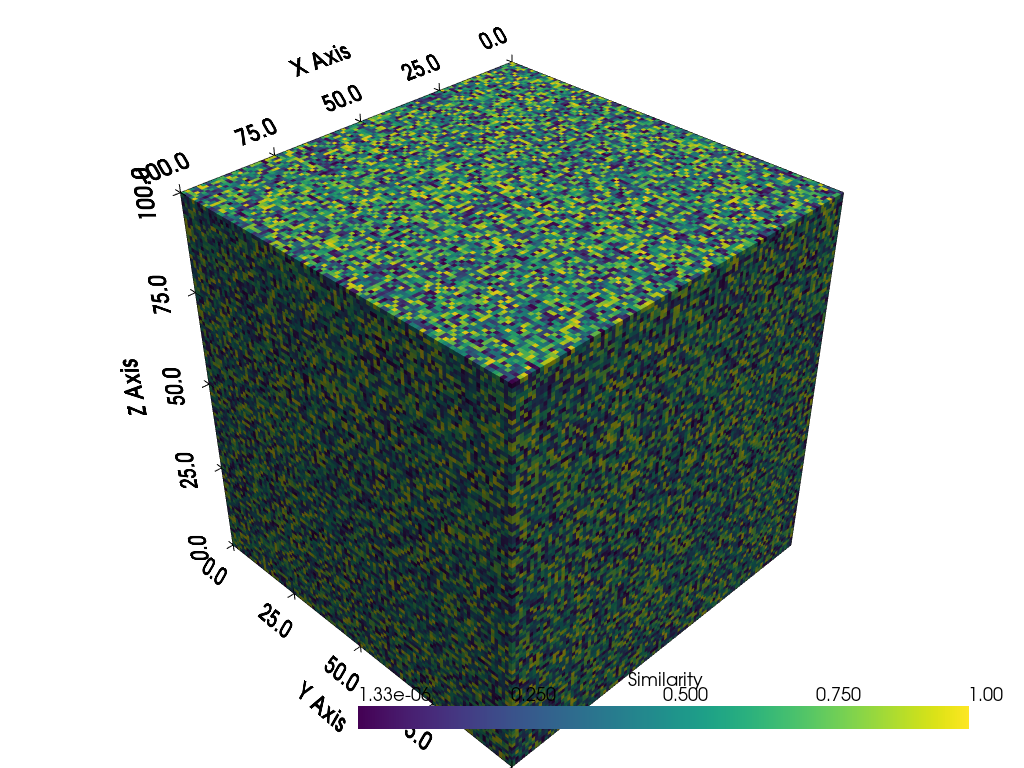

In [1]:
import numpy as np

import pyvista as pv
data = np.random.rand(100, 100, 100)  # Replace this with your actual 3D array data
similar_distance_map_rz = data
grid = pv.ImageData(dimensions=np.array(similar_distance_map_rz.shape)+1)  # Create an empty grid()
print(similar_distance_map_rz.flatten(order="F").shape)
print(grid.dimensions)
grid.cell_data["Similarity"] = similar_distance_map_rz.flatten(order="F")

# Create a plotter object and set the grid as the active scalar field
plotter = pv.Plotter()
plotter.add_mesh(grid, scalars="Similarity")
plotter.show_grid()
plotter.show()

In [2]:
from sklearn.model_selection import LeaveOneOut
def create_subject_pairs(root, id):
    data = []
    for root, dirs, files in os.walk(root):
        for filename in files:
            for image_id in id:
                if filename.endswith(image_id):
                    nifti_1 = tio.ScalarImage(os.path.join(root, filename))
                    try:
                        if "preop" in root:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("preop", "postop"), filename.replace("preop", "postop")))
                        else:
                            nifti_2 = tio.ScalarImage(os.path.join(root.replace("postop", "preop"), filename.replace("postop", "preop")))
                        if "-CON" in filename or "-CON" in os.path.join(root, filename):
                            # print("control for ", filename)
                            data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=1,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        elif "-PAT" in filename or "-PAT" in os.path.join(root, filename):
                                data.append(
                                tio.Subject(
                                    t1=nifti_1,
                                    t2=nifti_2,
                                    label=0,
                                    name= root.split("/")[-1],
                                    path= os.path.join(root, filename)
                                            )
                                    )
                        else:
                            print(f"Invalid filename: {os.path.join(root, filename)}")
                    except FileNotFoundError:
                        print(f"Matching subject (pre and post) not found for {os.path.join(root, filename)}")
    return data



def transform_subjects(subjects: list[tio.Subject]) -> tio.SubjectsDataset:
    transforms = [
    # tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.CropOrPad((164, 164, 164)),
    ]
    transform = tio.Compose(transforms)
    return tio.SubjectsDataset(subjects, transform=transform)

def create_loaders(dataset: Dataset, split=(0.6, 0.2, 0.2), generator=None):
    train_t1, val_t1, test_t1 = random_split(dataset=dataset, lengths=split, generator=generator)
    BATCH_SIZE=1
    train_loader_t1 = DataLoader(train_t1, batch_size=BATCH_SIZE, shuffle=False)
    val_loader_t1 = DataLoader(val_t1, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_t1 = DataLoader(test_t1, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader_t1, val_loader_t1, test_loader_t1

In [3]:
subjects_raw= create_subject_pairs(root= './data/processed/preop/BTC-preop', id=['t1_ants_aligned.nii.gz'])
subjects = transform_subjects(subjects_raw)
train_loader_t1, val_loader_t1, test_loader_t1 = create_loaders(subjects, split=(0.6, 0.2, 0.2), generator=torch.Generator().manual_seed(42))


In [5]:
loo = LeaveOneOut().split(subjects)
loo

<generator object BaseCrossValidator.split at 0x74f569e32020>

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(skf.split(subjects)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print(f"Fold {i} - Train: {len(train_index)} - Test: {len(test_index)}")

Fold 0 - Train: 23 - Test: 6
Fold 1 - Train: 23 - Test: 6
Fold 2 - Train: 23 - Test: 6
Fold 3 - Train: 23 - Test: 6
Fold 4 - Train: 24 - Test: 5


In [6]:
for i, (train_index, test_index) in enumerate(loo):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[0]
Fold 1:
  Train: index=[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[1]
Fold 2:
  Train: index=[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[2]
Fold 3:
  Train: index=[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[3]
Fold 4:
  Train: index=[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[4]
Fold 5:
  Train: index=[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[5]
Fold 6:
  Train: index=[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
  Test:  index=[6]
Fold 7:
  Train: index=[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 